In [11]:
import pandas as pd 
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report,accuracy_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
import os

In [5]:
cwd =os.getcwd()
os.chdir("/Users/luqingqi/Desktop/2022 datathon")

In [6]:
df = pd.read_csv('NJ-total.csv', header= 0,
                        encoding= 'unicode_escape')

0    3370
1    2260
Name: GAMERESULTS, dtype: int64


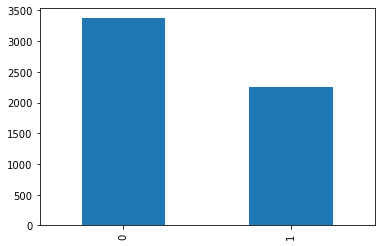

In [9]:
color_wheel = {1: "#0392cf", 
               2: "#7bc043"}
colors = df["GAMERESULTS"].map(lambda x: color_wheel.get(x + 1))
print(df.GAMERESULTS.value_counts())
p=df.GAMERESULTS.value_counts().plot(kind="bar")

In [14]:
df=df.drop('DATE', axis =1)

In [15]:
df=df.drop('TIMESTAMP', axis =1)

In [16]:
df=df.drop('CONTENT_TEXT', axis =1)

In [17]:
df=df.drop('CONTENT_HASHTAGS', axis =1)

In [18]:
df=pd.get_dummies(df)

# Build A Preliminary Classification Tree

In [19]:
y = df.GAMERESULTS
X = df.drop('GAMERESULTS', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42,test_size=0.25)

## create a decision tree fit it to the training data 
clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
clf_dt = clf_dt.fit(X_train,y_train)

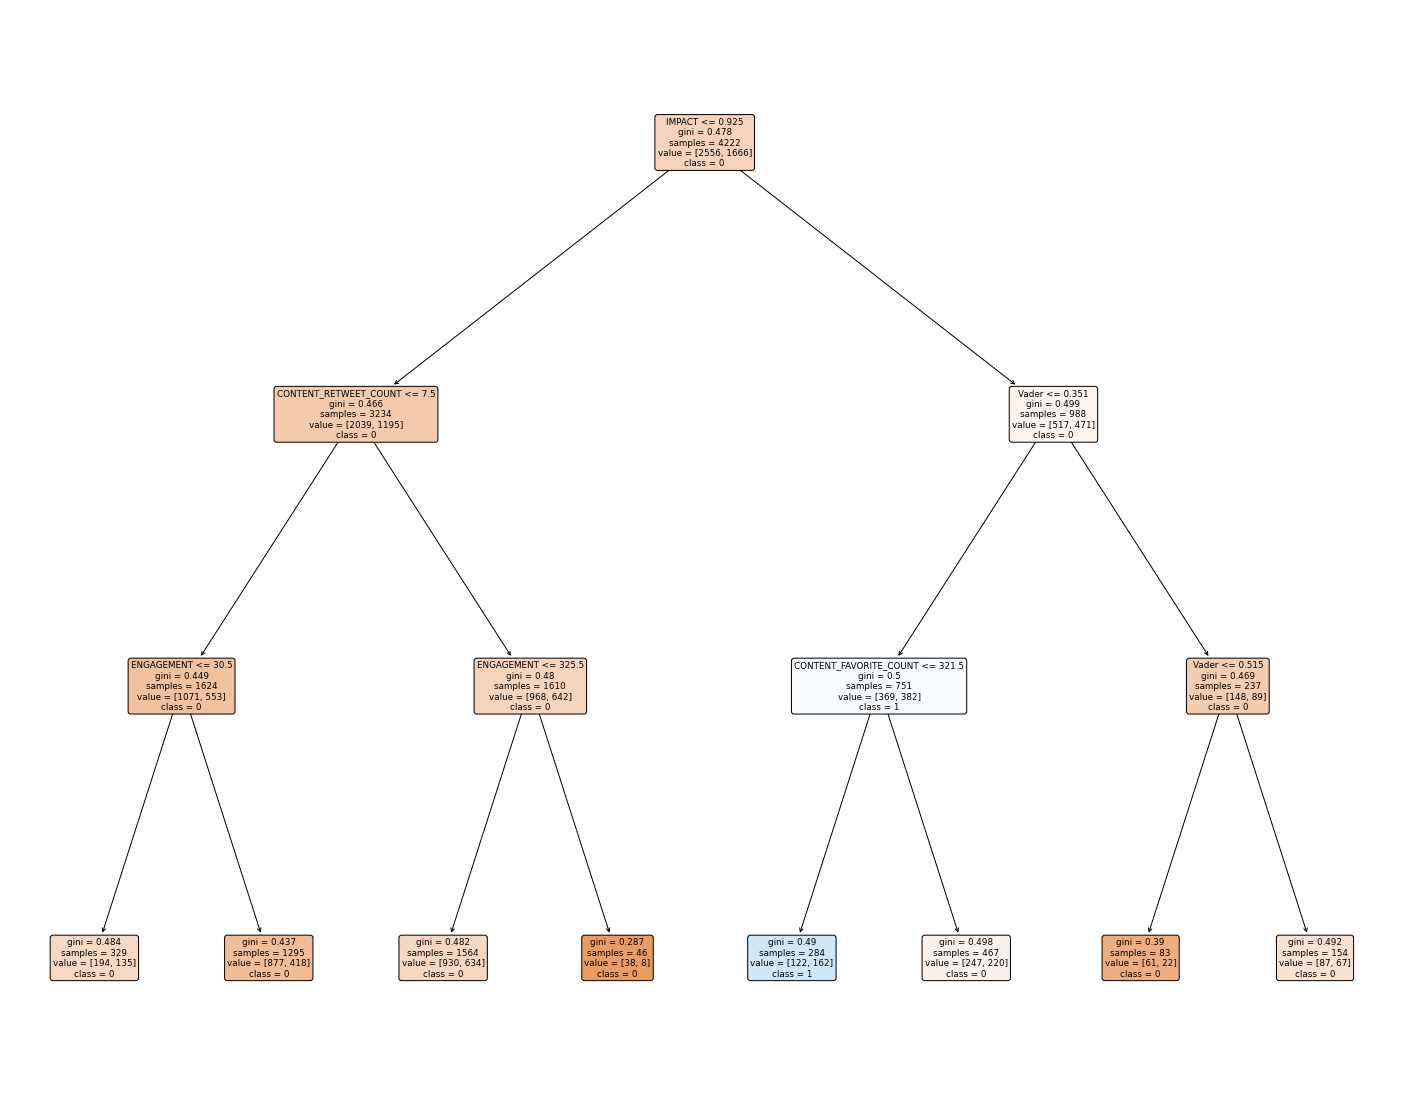

In [23]:
plt.figure(figsize=(25, 20))
plot_tree(clf_dt,
          filled=True,
          rounded=True,
          class_names = ["0","1"],
          feature_names=X.columns);

In [24]:
y_pred = clf_dt.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[757  57]
 [555  39]]


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.93      0.71       814
           1       0.41      0.07      0.11       594

    accuracy                           0.57      1408
   macro avg       0.49      0.50      0.41      1408
weighted avg       0.50      0.57      0.46      1408



In [9]:
#Accuracy = 100%

# Cost Complexity Pruning Part1 :Visualize alpha 

## Decision Trees 
are notorious for being overfit to the Training Dataset, and there are a lot of parameters, like max_depth and min_samples, that are designed to reduce overfitting. However, pruning a tree with cost complexity pruning can simplify the whole process of finding a smaller tree that imporves the accuracy with Testing Dataset

## Purning a decision tree 
is all about finding the right value for the pruning parameter, alpha, which controls how little or how much pruning happens. One way to find the optimal value for alpha is to plot the accuracy of the tree as a function of different values. We'll do this for both the Training Dataset and the Testing Dataset

First, lets extract the different values of alpha that are available for this tree and build a pruned tree for each value for alpha. Note: We omit the maximum value for alpha with ccp_alphas = ccp_alphas[:-1] because would prune all leaves, leaving us with only a root insted of a tree.

In [26]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) # determine values for alpha
ccp_alphas = path.ccp_alphas  # extract different values for alpha 
ccp_alphas = ccp_alphas[:-1]  # exclude the maximum value for alpha 

clf_dts =[] # create an array that we will put decision trees it in the array 

##
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier( random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

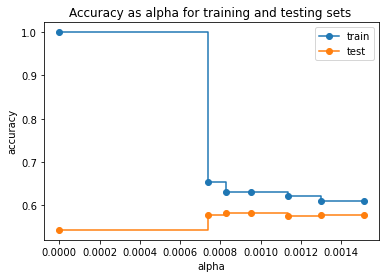

In [27]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy as alpha for training and testing sets ")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [28]:
# ccp_alpha = 0.001

<AxesSubplot:xlabel='tree'>

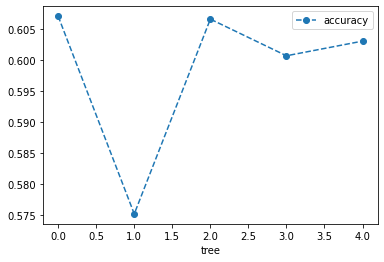

In [29]:
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0.001)
scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})
df.plot(x='tree', y='accuracy', marker='o', linestyle = '--')

In [30]:
alpha_loop_values =[]

<AxesSubplot:xlabel='alpha'>

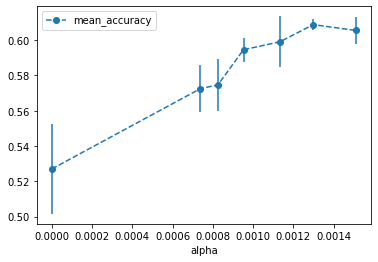

In [31]:
## fOr each candidate value for alpha, we will run 5-fold cross validation 
## Then we will store the mean and standard devation of the scores (the accuracy) for each call
## to cross_val_score in alpha_loop_values.. 

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
## Now we can draw a graph of the means and standard deviations of the scores 
## for each candidate value for alpha 
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha','mean_accuracy','std'])

alpha_results.plot(x='alpha',y='mean_accuracy',yerr='std',marker='o',linestyle='--')

In [53]:
ideal_ccp_alpha = 0.0013

In [54]:
clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

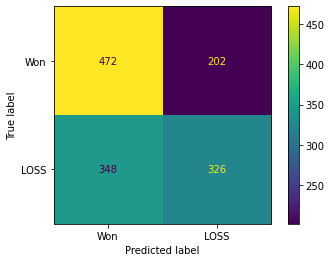

In [55]:
plot_confusion_matrix(clf_dt_pruned,
                      X_test,
                      y_test,
                      display_labels=["Won", "LOSS"])

In [52]:
 (412+256)/(293+381)

0.9910979228486647

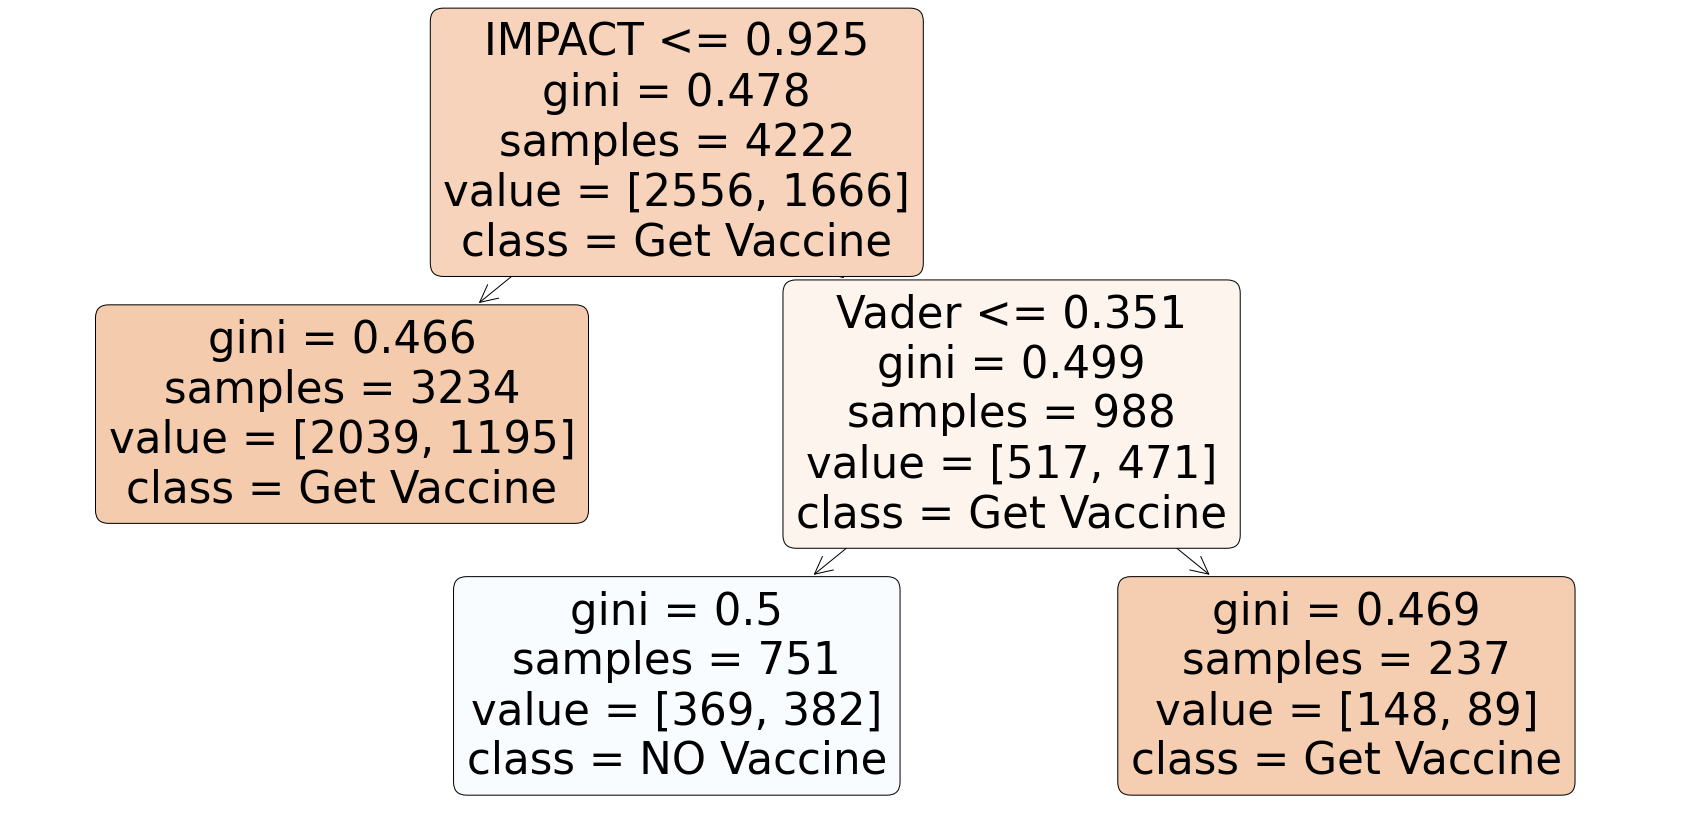

In [35]:
plt.figure(figsize = (30, 15))
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["Get Vaccine", "NO Vaccine"],
          feature_names= X.columns);

In [56]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X,y)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.2, random_state=15, stratify=y_smote)

In [58]:
## create a decision tree fit it to the training data 
clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
clf_dt = clf_dt.fit(X_train,y_train)

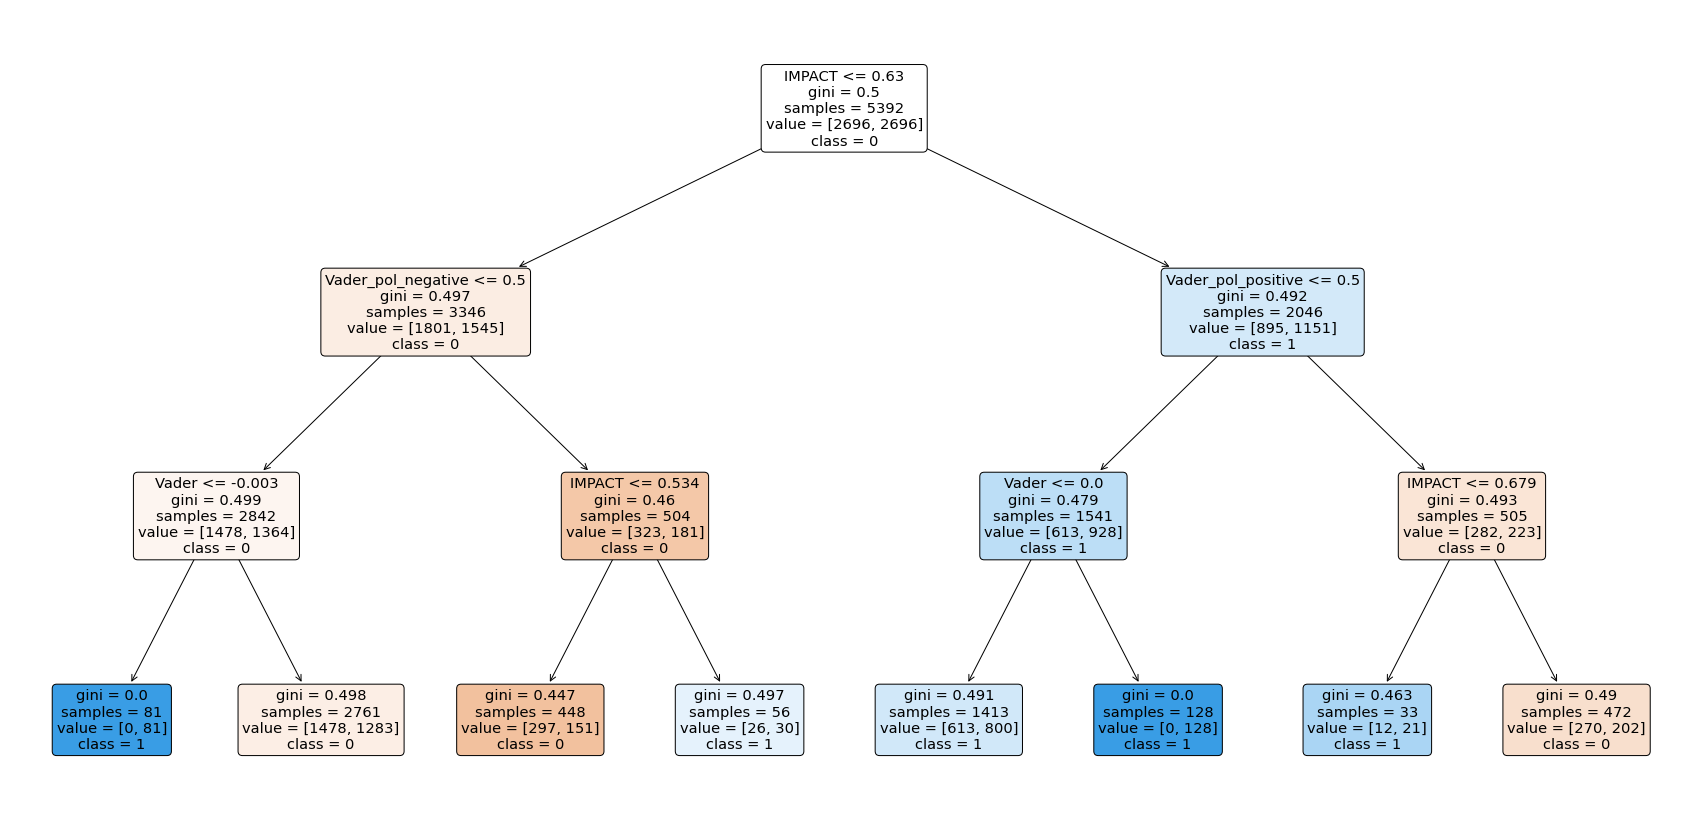

In [59]:
plt.figure(figsize=(30, 15))
plot_tree(clf_dt,
          filled=True,
          rounded=True,
          class_names = ["0","1"],
          feature_names=X.columns);

In [40]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) # determine values for alpha
ccp_alphas = path.ccp_alphas  # extract different values for alpha 
ccp_alphas = ccp_alphas[:-1]  # exclude the maximum value for alpha 

clf_dts =[] # create an array that we will put decision trees it in the array 

##
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier( random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

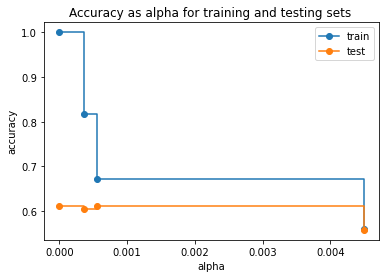

In [41]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy as alpha for training and testing sets ")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

<AxesSubplot:xlabel='tree'>

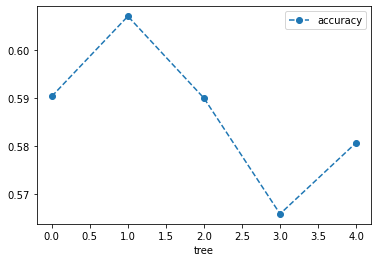

In [42]:
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0.001)
scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})
df.plot(x='tree', y='accuracy', marker='o', linestyle = '--')

In [43]:
alpha_loop_values =[]

<AxesSubplot:xlabel='alpha'>

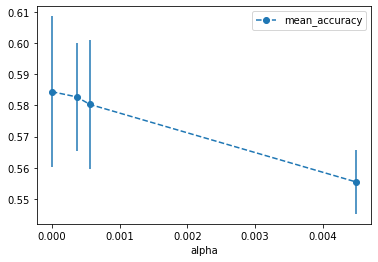

In [44]:
## fOr each candidate value for alpha, we will run 5-fold cross validation 
## Then we will store the mean and standard devation of the scores (the accuracy) for each call
## to cross_val_score in alpha_loop_values.. 

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
## Now we can draw a graph of the means and standard deviations of the scores 
## for each candidate value for alpha 
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha','mean_accuracy','std'])

alpha_results.plot(x='alpha',y='mean_accuracy',yerr='std',marker='o',linestyle='--')

In [45]:
ideal_ccp_alpha = 0.00125

In [46]:
clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

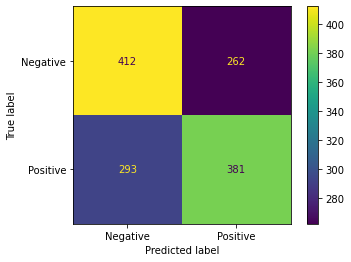

In [47]:
y_pred = clf_dt_pruned.predict(X_test)
plot_confusion_matrix(clf_dt_pruned,
                      X_test,
                      y_test,
                      display_labels=["Negative", "Positive"])

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.61      0.60       674
           1       0.59      0.57      0.58       674

    accuracy                           0.59      1348
   macro avg       0.59      0.59      0.59      1348
weighted avg       0.59      0.59      0.59      1348



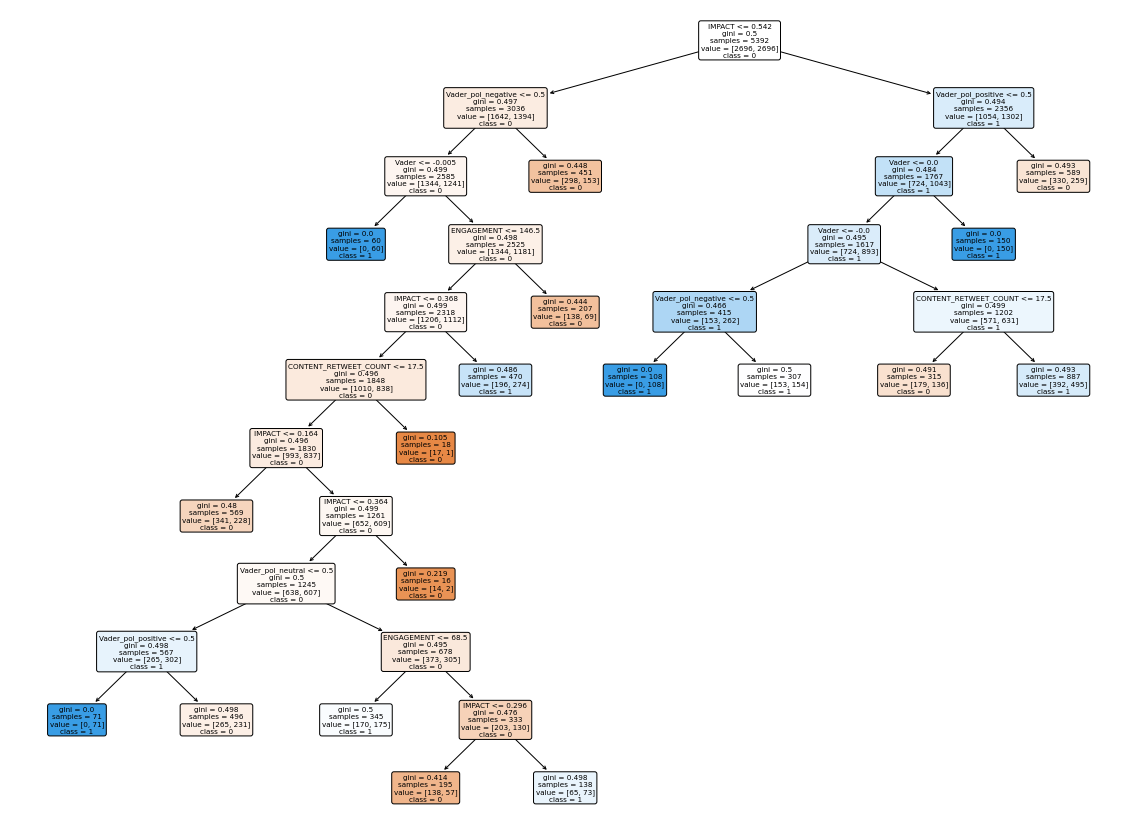

In [50]:
plt.figure(figsize = (20, 15))
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["0", "1"],
          feature_names= X.columns);